# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Требование - построить модель со значением метрики качества *F1* не меньше 0.75. 

**Краткий план выполнения проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделаем выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik -q

In [3]:
!pip install scikit-learn==1.3.2 -q

In [4]:
!pip install -U spacy -q

In [5]:
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
!pip install lightgbm -q

In [26]:
# импортируем все необходимые библиотеки 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer 

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from sklearn.inspection import permutation_importance
import phik
from numpy import quantile
from sklearn.dummy import DummyRegressor
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer)
import spacy
nlp = spacy.load("en_core_web_sm")
RANDOM_STATE = 42
TEST_SIZE = 0.2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных.

In [8]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Удалим ненужный столбец.

In [9]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Взглянем на общую информацию о таблице, проверим наличие пропусков и дубликатов.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [11]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [12]:
data.duplicated().sum()

0

Типы данных соотвествуют истенным, пропусков и дубликатов нет.

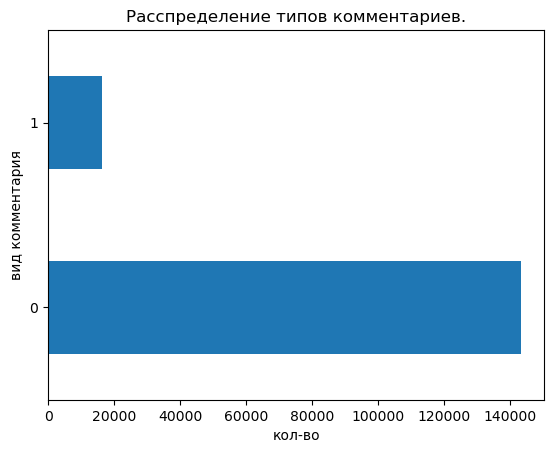

In [13]:
data['toxic'].value_counts().plot.barh()
plt.xlabel('кол-во')
plt.ylabel('вид комментария')
plt.title('Расспределение типов комментариев.')
plt.show()

В данных есть дисбаланс классов, учтем это при построении моделей.

### Вывод по загрузке данных:
Типы данных соотвествуют истенным, пропусков и дубликатов нет. В данных есть дисбаланс классов, учтем это при построении моделей.

## Подготовка.

Создадим функцию для отчистки текста от ненужных символов, так же привидем содержимое строк к нижнему регистру.

In [14]:
def clear_text(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

data['text'] = data['text'].apply(clear_text)
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


Теперь произведем лемматизацию.

In [15]:

lemma = []
 
for doc in nlp.pipe(data.text.values):
    lemma.append([n.lemma_ for n in doc])
    
    
data['lemma'] = lemma    
data['text_lemma'] = data['lemma'].apply(lambda x: ' '.join(x))
data = data.drop(['text', 'lemma'], axis=1)
data.head(10)

,toxic,text_lemma
0,0,explanation why the edit make under my usernam...
1,0,daww he match this background colour I m seemi...
2,0,hey man I m really not try to edit war its jus...
3,0,more I can not make any real suggestion on imp...
4,0,you sir be my hero any chance you remember wha...
5,0,congratulation from I as well use the tool wel...
6,1,cocksucker before you piss around on my work
7,0,your vandalism to the matt shirvington article...
8,0,sorry if the word nonsense be offensive to you...
9,0,alignment on this subject and which be contrar...


In [16]:
data.shape

(159292, 2)

Разделим датасет на тестовые, валидационные и тренировочные выборки.

In [17]:
X = data.drop(['toxic'], axis = 1)
y = data['toxic']

X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.5, 
                                                      random_state=RANDOM_STATE, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, 
                                                    y_valid, 
                                                    test_size=0.5,
                                                    random_state=RANDOM_STATE, stratify= y_valid)

Проверим размерность получившихся наборов данных.

In [18]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)
print()
print(X_valid.shape)
print(y_valid.shape)

(79646, 1)
(79646,)

(39823, 1)
(39823,)

(39823, 1)
(39823,)


Далее преобразуем содержимое строк в векторы и проверим размерность.

In [19]:
corpus_train = X_train['text_lemma'].values.astype('U')
corpus_test = X_test['text_lemma'].values.astype('U')
corpus_valid = X_valid['text_lemma'].values.astype('U')

count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_valid = count_tf_idf.transform(corpus_valid)
tf_idf_test = count_tf_idf.transform(corpus_test)

print(tf_idf_train.shape)
print(tf_idf_valid.shape)
print(tf_idf_test.shape)

(79646, 127944)
(39823, 127944)
(39823, 127944)


### Вывод по подготовке данных:
1. Создали функцию для отчистки текста от ненужных символов, так же привили содержимое строк к нижнему регистру.
2. Провели лемматизацию.
3. Разделили датасет на тестовые, валидационные и тренировочные выборки.
4. Преобразовали данные в вектора.

## Обучение.

Создадим функцию, которая будет принимать тренировочные и валидационные данные, словарь с гиперпараметрами и модель. На выходе получим метрики "F1" и "ROC-AUC" и гиперпараметры лучшей модели.

In [21]:
def create_model(tf_idf_train, tf_idf_valid, y_train, y_valid, param_grid, model):
   
    randomized_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='f1',
        random_state=RANDOM_STATE,
        n_iter=4,
        n_jobs=-1,    
    )
    
    randomized_search.fit(tf_idf_train, y_train)
    
    best_params = randomized_search.best_params_
    print('Лучшие параметры:\n\n', best_params)
    
    f1_score_train = randomized_search.best_score_
    
    print('Метрика F1 лучшей модели на тренировочной выборке:', f1_score_train)
    
    best_model = randomized_search.best_estimator_
    
    # Предсказываем метки для валидационных данных
    y_pred_valid = best_model.predict(tf_idf_valid)
    
    # Вычисляем F1 на валидационной выборке
    f1_score_valid = f1_score(y_valid, y_pred_valid)
    
    print('Метрика F1 лучшей модели на валидационной выборке:', f1_score_valid)
    
    # Вычисляем ROC AUC для лучшей модели на валидационных данных
    y_pred_proba = best_model.predict_proba(tf_idf_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    
    print('Метрика ROC AUC лучшей модели на валидационной выборке:', roc_auc)
    
    return best_model

In [22]:
# словарь для модели LGBMClassifier()
lgbm_param_grid = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'num_leaves' : range(20,70,5),
        'verbose' : [0],
        'random_state' : [RANDOM_STATE],
        'force_col_wise': [True]
        }

In [23]:
# словарь для модели LogisticRegression()
logistic_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]  
}


In [35]:
# словарь для модели RandomForestClassifier()
random_forest_param_grid = {
    'n_estimators': range(50, 300,30),
    'max_depth': range(7,50,2) ,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

In [27]:
log_model = create_model(tf_idf_train, tf_idf_valid, y_train, y_valid, logistic_param_grid, LogisticRegression())

Лучшие параметры:

 {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100, 'C': 100}
Метрика F1 лучшей модели на тренировочной выборке: 0.7521577653696214
Метрика F1 лучшей модели на валидационной выборке: 0.756126958617919
Метрика ROC AUC лучшей модели на валидационной выборке: 0.9565990191336325


In [36]:
random_forest_model = create_model(tf_idf_train, tf_idf_valid, y_train, y_valid,
                                   random_forest_param_grid, RandomForestClassifier())

Лучшие параметры:

 {'n_estimators': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 43, 'class_weight': 'balanced'}
Метрика F1 лучшей модели на тренировочной выборке: 0.45113756461180676
Метрика F1 лучшей модели на валидационной выборке: 0.4524998191158382
Метрика ROC AUC лучшей модели на валидационной выборке: 0.8777094465665726


In [30]:
lgbm_model = create_model(tf_idf_train, tf_idf_valid, y_train, y_valid,
                                   lgbm_param_grid, LGBMClassifier())

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Лучшие параметры:

 {'verbose': 0, 'random_state': 42, 'num_leaves': 50, 'n_estimators': 70, 'max_depth': 13, 'force_col_wise': True}
Метрика F1 лучшей модели на тренировочной выборке: 0.6810283938155488
Метрика F1 лучшей модели на валидационной выборке: 0.6890159122508882
Метрика ROC AUC лучшей модели на валидационной выборке: 0.9449018959581801


Лучшие показатели у модели LogisticRegression: метрика F1 на валидационной выборке: 0.756126958617919 и ROC AUC на валидационной выборке: 0.9565990191336325. Именно эту модель будем использовать для предсказания на тестовых данных.

In [34]:
y_pred_test = log_model.predict(tf_idf_test)
    
f1_score_test = f1_score(y_test, y_pred_test)
print('Метрика F1 лучшей модели на тестовой выборке:', f1_score_test)

Метрика F1 лучшей модели на валидационной выборке: 0.7569678201157937


## Вывод.
В ходе работы были протестированны три модели - LogisticRegression, RandomForestClassifier и LGBMClassifier. Лучшие показатели у LogisticRegression, на тестовых данных метрика F1 составила 0.7569678201157937, что подходит под требования задачи -  F1 не меньше 0.75.